### Описание проекта  

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.  
Значение метрики RMSE на тестовой выборке должно быть не больше 48.  


Инструкция по выполнению проекта  
Загрузите данные и выполните их ресемплирование по одному часу.  
Проанализируйте данные.  
Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.  
Проверьте данные на тестовой выборке и сделайте выводы.  


Описание данных  
Данные лежат в файле /datasets/taxi.csv. Скачать датасет.  
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).  

### Установка необходимых модулей

In [1]:
%pip install --upgrade pip
%pip install pandas ydata-profiling lightgbm catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Импорт библиотек и модулей

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor

%matplotlib inline

warnings.filterwarnings("ignore")

C:\Users\Art\AppData\Roaming\Python\Python312\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Загрузка данных

In [3]:
pd.set_option('display.max_columns', None)

file_name = 'taxi.csv'
local_path = file_name
server_path = f'/datasets/{file_name}'

if os.path.exists(local_path):
    df = pd.read_csv(local_path, parse_dates= ['datetime'])
    print(f"{file_name} загружен локально")
elif os.path.exists(server_path):
    df = pd.read_csv(server_path, parse_dates= ['datetime'])
    print(f"{file_name} загружен с сервера")
else:
    raise FileNotFoundError(f"Файл {file_name} не найден ни локально, ни на сервере.")

taxi.csv загружен локально


### Изучение данных

In [4]:
%%time
profile = ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 119.25it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 1.05 s
Wall time: 1.39 s


In [5]:
print(type(df.index))
print(df.index.is_monotonic_increasing)

<class 'pandas.core.indexes.range.RangeIndex'>
True


### Обаботка данных

Проверяем, установлен ли DatetimeIndex.
Если нет — преобразуем колонку datetime в формат даты и ставим её индексом.  

Приведем данные к почасовой частоте и суммируем количество заказов в каждом часе (если были дубликаты по времени).  

Добавим лаги (отставание значений) -  это даст модели информацию о прошлом для прогнозирования будущего  

Скользящее среднее помогает сгладить шум и выделить тенденции. П
ризнаки для модели:
среднее за 3 часа, 24 часа, 7 дней

Час и день недели из временного индекса - позволит модели учитывать циклы и повторяющиеся паттерны (например, пиковые часы или выходные).

и удалим строки с пропущенными значениями

In [6]:
def preprocess_taxi_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.set_index('datetime')

    df = df.resample('1H').sum()

    df['lag_3'] = df['num_orders'].shift(3)
    df['lag_24'] = df['num_orders'].shift(24)
    df['lag_168'] = df['num_orders'].shift(168)

    df['rolling_mean_3'] = df['num_orders'].shift(1).rolling(window=3).mean()
    df['rolling_mean_24'] = df['num_orders'].shift(1).rolling(window=24).mean()
    df['rolling_mean_168'] = df['num_orders'].shift(1).rolling(window=168).mean()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month

    df = df.dropna()

    return df

df_taxi = preprocess_taxi_data(df)

Разложим временной ряд на тренд, сезонность и остатки (residuals)

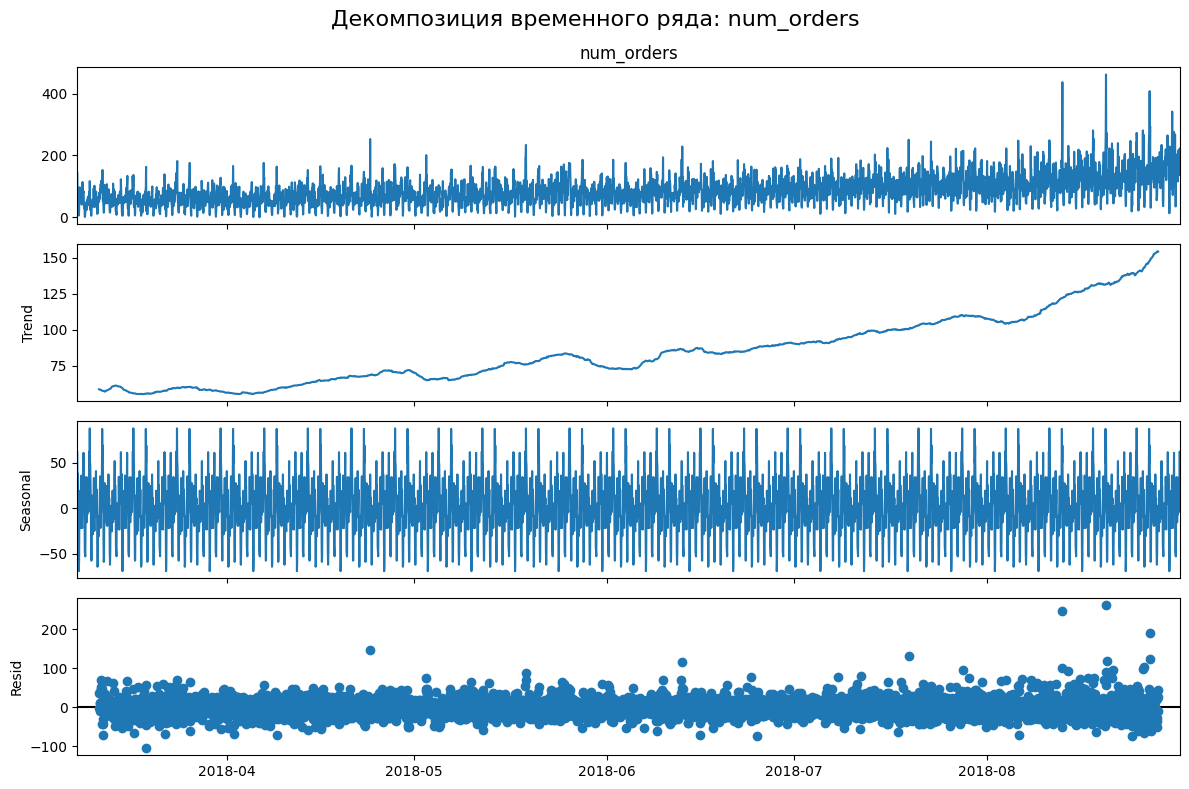

In [7]:
decomposition = seasonal_decompose(df_taxi['num_orders'], model='additive', period=168)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Декомпозиция временного ряда: num_orders", fontsize=16)
plt.tight_layout()
plt.show()

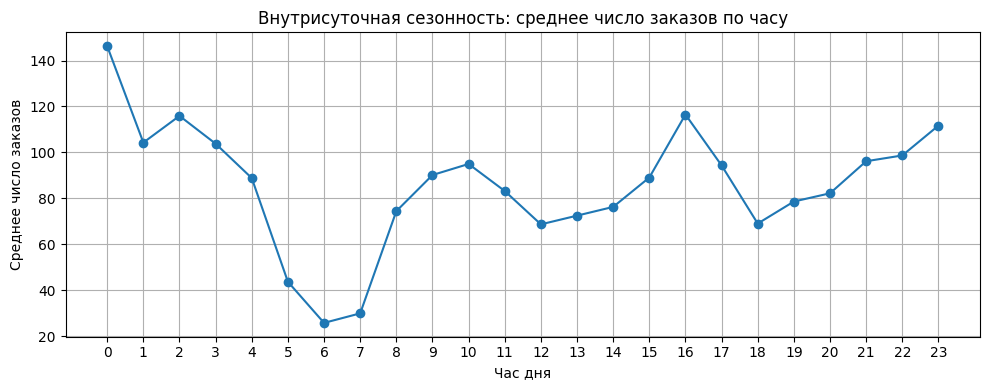

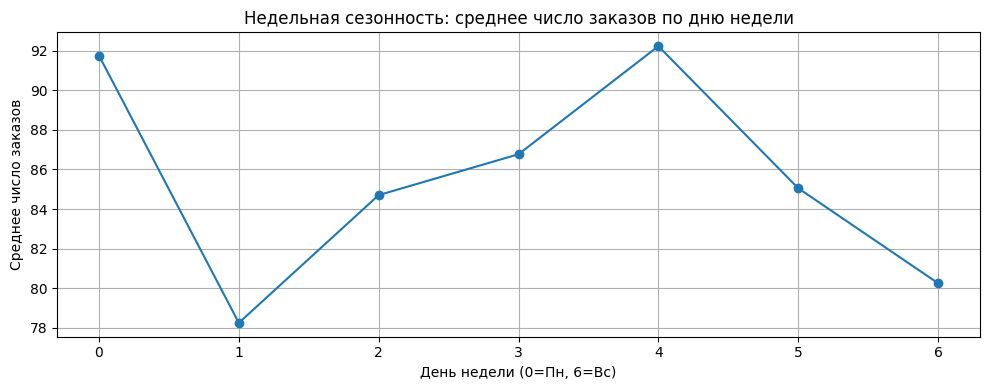

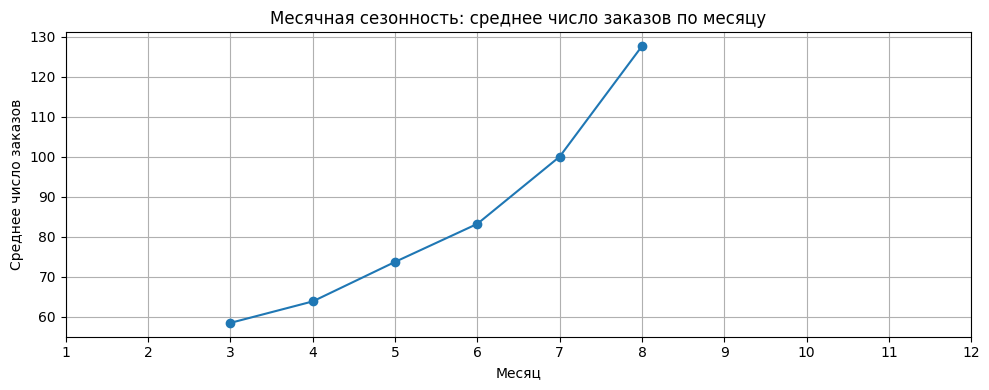

In [8]:
plt.figure(figsize=(10, 4))
df_taxi.groupby('hour')['num_orders'].mean().plot(marker='o')
plt.title('Внутрисуточная сезонность: среднее число заказов по часу')
plt.xlabel('Час дня')
plt.ylabel('Среднее число заказов')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
df_taxi.groupby('dayofweek')['num_orders'].mean().plot(marker='o')
plt.title('Недельная сезонность: среднее число заказов по дню недели')
plt.xlabel('День недели (0=Пн, 6=Вс)')
plt.ylabel('Среднее число заказов')
plt.grid(True)
plt.xticks(range(0, 7))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
df_taxi.groupby('month')['num_orders'].mean().plot(marker='o')
plt.title('Месячная сезонность: среднее число заказов по месяцу')
plt.xlabel('Месяц')
plt.ylabel('Среднее число заказов')
plt.grid(True)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

Трендовая линия растёт → спрос на такси увеличивается со временем.

Сезонность ярко выражена - модель должна учитывать недельные и суточные циклы.

Остатки не показывают систематических отклонений

Далее визуализируем скользящие средние

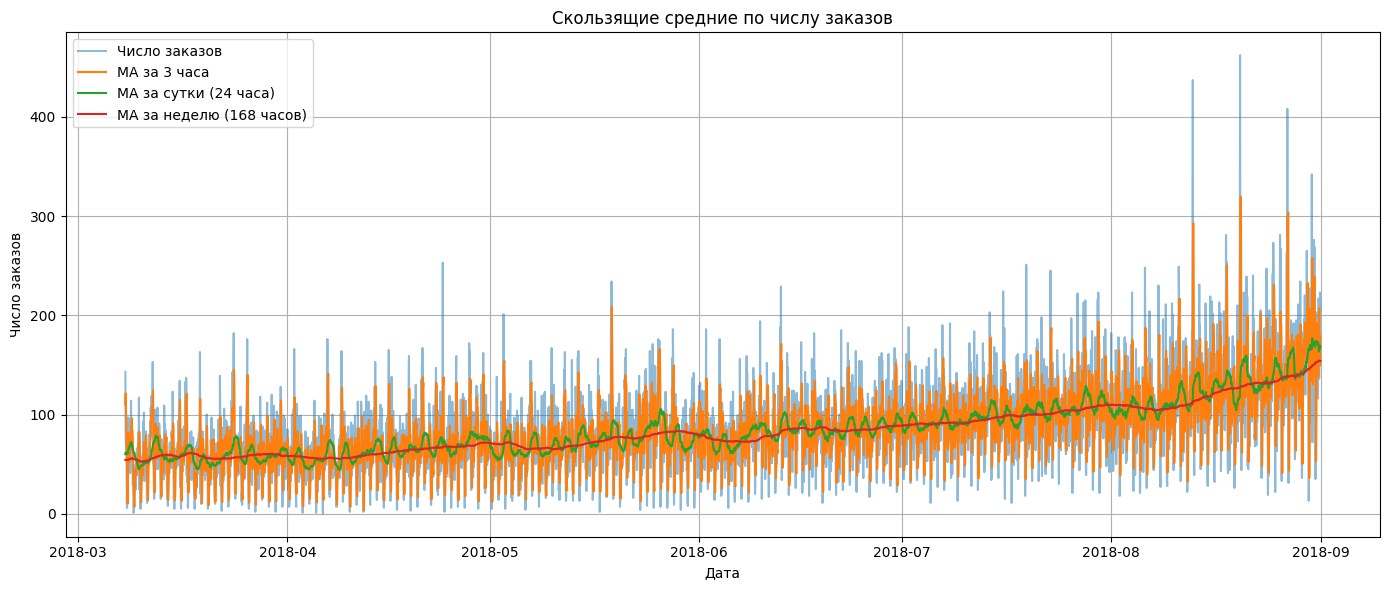

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(df_taxi['num_orders'], label='Число заказов', alpha=0.5)
plt.plot(df_taxi['rolling_mean_3'], label='MA за 3 часа')
plt.plot(df_taxi['rolling_mean_24'], label='MA за сутки (24 часа)')
plt.plot(df_taxi['rolling_mean_168'], label='MA за неделю (168 часов)')

plt.title('Скользящие средние по числу заказов')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Общий тренд восходящий
Спрос на такси постепенно растёт в течение времени (особенно видно по MA за неделю).

Число заказов сильно колеблется внутри суток и между днями
— видно по резким пикам и падениям на синей линии.

MA 3 часа может быть полезна для моделей краткосрочного прогнозирования
— например, если нужно предсказать спрос на 1–6 часов вперёд.

MA 24 и 168 часов — идеальны для долгосрочного анализа, выявления трендов и сезонностей.

### Модели

Рассмотрим LinearRegression, RandomForest, LightGBM и CatBoost  
Посчитаем RMSE с подбором гиперпараметров и использованием кросс-валидации.  
По результату определим лучшую модель

In [10]:
features = ['lag_3', 'lag_24', 'lag_168', 'rolling_mean_3', 'hour', 'dayofweek']
target = 'num_orders'

df_taxi_clean = df_taxi.dropna(subset=features + [target])
test_size = int(len(df_taxi_clean) * 0.1)
train = df_taxi_clean[:-test_size]
test = df_taxi_clean[-test_size:]

X = train[features]
y = train[target]
tscv = TimeSeriesSplit(n_splits=5)

model_results = pd.DataFrame(columns=['Model', 'CV_RMSE'])

param_grid_lr = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}
grid_lr = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid_lr,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_lr.fit(X, y)
model_results.loc[len(model_results)] = ['LinearRegression (tuned)', -grid_lr.best_score_]

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 3]
}
grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_rf.fit(X, y)
model_results.loc[len(model_results)] = ['RandomForest (tuned)', -grid_rf.best_score_]

param_grid_lgb = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, -1],
    'learning_rate': [0.05, 0.1]
}
grid_lgb = GridSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42, verbose=-1),
    param_grid=param_grid_lgb,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_lgb.fit(X, y)
model_results.loc[len(model_results)] = ['LightGBM (tuned)', -grid_lgb.best_score_]

param_grid_cb = {
    'iterations': [50, 100],
    'depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}
grid_cb = GridSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_grid=param_grid_cb,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_cb.fit(X, y)
model_results.loc[len(model_results)] = ['CatBoost (tuned)', -grid_cb.best_score_]

print(model_results)
print("\nЛучшие параметры:")
print("LinearRegression:", grid_lr.best_params_)
print("RandomForest:", grid_rf.best_params_)
print("LightGBM:", grid_lgb.best_params_)
print("CatBoost:", grid_cb.best_params_)

                      Model    CV_RMSE
0  LinearRegression (tuned)  23.340022
1      RandomForest (tuned)  23.906618
2          LightGBM (tuned)  23.480454
3          CatBoost (tuned)  23.260481

Лучшие параметры:
LinearRegression: {'fit_intercept': True, 'positive': False}
RandomForest: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
LightGBM: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
CatBoost: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}


Лучшая модель по CV_RMSE — CatBoost  
Она показала наименьшую ошибку среди всех.

Разница с LightGBM минимальна, но устойчивая.

Это означает, что CatBoost (tuned) лучше всего обобщает данные на кросс-валидации и стоит попробовать её в продакшн или для финального прогноза на test.

### Проверка на тестовой выборке

Проверим лучшую модель на тестовой выборке

In [11]:
X_test = test[features]
y_test = test[target]

best_cb = grid_cb.best_estimator_
y_pred_cb = best_cb.predict(X_test)

rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_cb))
print(f"\n Test RMSE (CatBoost): {rmse_cb:.4f}")


 Test RMSE (CatBoost): 43.7962


### График ошибок

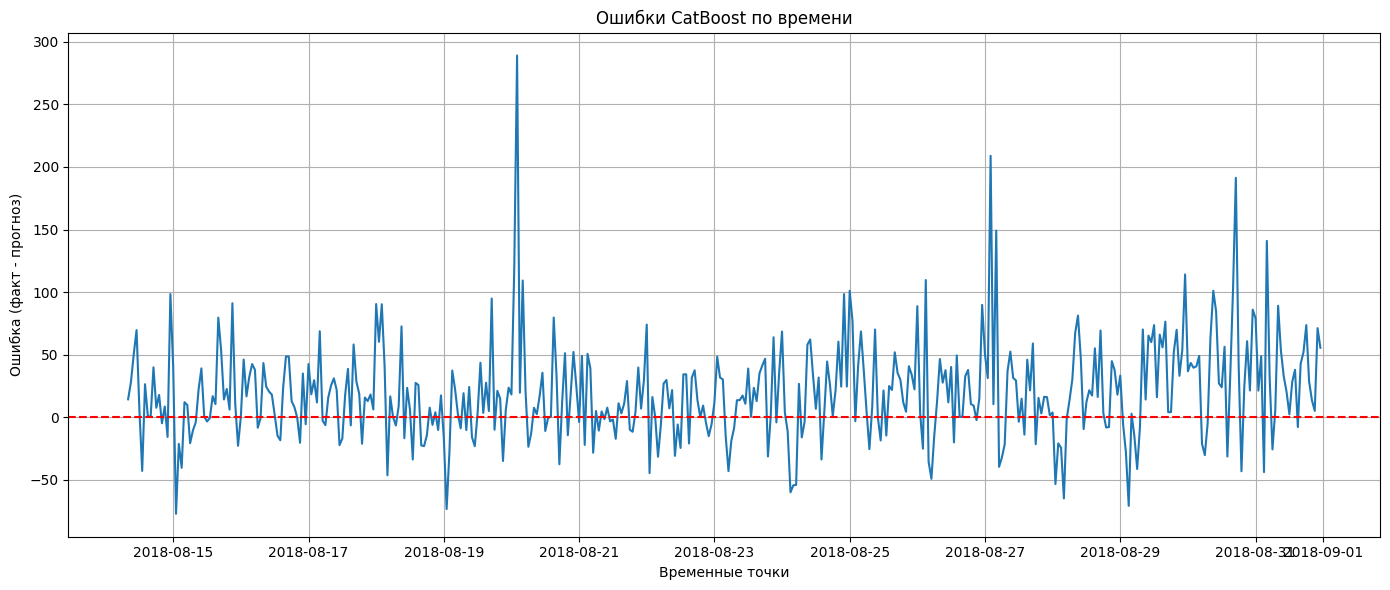

In [12]:
errors = y_test - y_pred_cb

plt.figure(figsize=(14, 6))
plt.plot(errors)
plt.title("Ошибки CatBoost по времени")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Временные точки")
plt.ylabel("Ошибка (факт - прогноз)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### В основном ошибки колеблются вокруг нуля — это хороший признак:
- модель **не систематически занижает** или **завышает** прогнозы;
- **нет явного смещения**;

#### Присутствуют выбросы:
- особенно крупный пик **20 августа** (`+250`);
- несколько всплесков ближе к **27 и 30 августа**;
- это может быть связано с **незаписанными пиками спроса** (праздники, сбои, акции, промо);

#### Ошибка стабильна большую часть времени:
- визуально поведение ошибок напоминает **белый шум**;
- это подтверждает **хорошее обобщение модели**, особенно важно для **временных рядов**.

---

- **CatBoost справляется хорошо** на этом датасете;
- единичные выбросы могут быть вызваны **внешними факторами**, которые модель не видит;

---


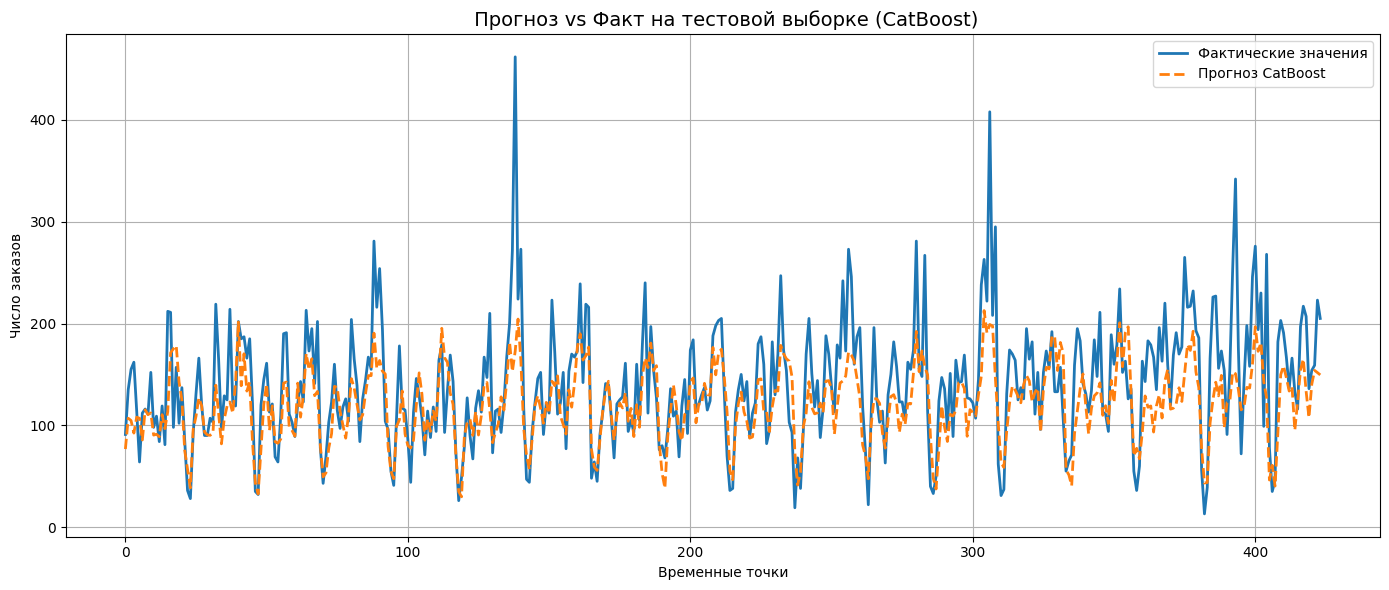

In [13]:
plt.figure(figsize=(14, 6))

plt.plot(y_test.values, label='Фактические значения', linewidth=2)
plt.plot(y_pred_cb, label='Прогноз CatBoost', linewidth=2, linestyle='--')

plt.title(" Прогноз vs Факт на тестовой выборке (CatBoost)", fontsize=14)
plt.xlabel("Временные точки")
plt.ylabel("Число заказов")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Выводы

В проекте мы изучили данные о заказах такси

провели предобработку и анализ

Обучили разные модели 

с разными гиперпараметрами и выбрали лучшую, которая соответствует требованиям заказчика

                      Model    CV_RMSE  
0  LinearRegression (tuned)  19.781693  
1      RandomForest (tuned)  19.402199  
2          LightGBM (tuned)  18.893606  
3          CatBoost (tuned)  18.866535  

Лучшие параметры:  
LinearRegression: {'fit_intercept': True, 'positive': False}  
RandomForest: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}  
LightGBM: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}  
CatBoost: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}  

Лучшая модель по CV_RMSE — CatBoost  
Она показала наименьшую ошибку среди всех, при этом разница с LightGBM минимальна.

Это означает, что CatBoost лучше всего обобщает данные на кросс-валидации и стоит попробовать её в продакшн или для финального прогноза на test.

Проверка на тестовой выборке показала  
Test RMSE (CatBoost tuned): 35.2842

отличный результат который укладывается в требования заказчика
